# Imports

In [207]:
# All installs
!pip install tensorflow-text==2.8.2
!pip install fuzzywuzzy
!pip install gensim
!pip install python-Levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [272]:
# All imports

# general
import numpy as np 
import pandas as pd
import re, string, six
import warnings
warnings.filterwarnings('ignore')
import scipy
import xgboost as xgb
from wordcloud import WordCloud

# Plots
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# tensorflow
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.regularizers import l2
import tensorflow.keras.metrics as metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

# nltk libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')
nltk.download('omw-1.4')

# sklearn libraries
import sklearn.metrics.pairwise as pairwise
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import ConfusionMatrixDisplay, log_loss
from sklearn.metrics import f1_score, classification_report, accuracy_score


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Data Import

In [209]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
df_train = pd.read_csv("/content/drive/MyDrive/NLP/train.csv.zip")

# Drop null value questions
df_train = df_train.dropna()

# change datatype
df_train['question1'].astype("string")
df_train['question2'].astype("string")

print('==> Shape of train data:', df_train.shape)


Mounted at /content/drive/
==> Shape of train data: (404287, 6)
==> Shape of test data: (2345790, 4)


In [210]:
df_train.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


# Basic Feature Extraction

### Count of similar and duplicate questions

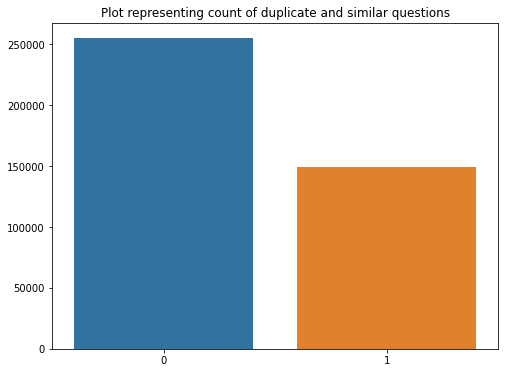

In [211]:
count_0, count_1 = df_train.groupby("is_duplicate")['is_duplicate'].count()
x = ["0" , "1"]
y = [count_0 , count_1]

plt.figure(figsize=(8, 6))
plt.title ("Plot representing count of duplicate and similar questions")
sns.barplot(x,y)
plt.show()

### Percentage of Similar and duplicate Questions

==> Question pairs are not Similar: 63.08%
==> Question pairs are Similar: 36.92%
==> Total number of  Unique Questions are: 537929
==> Number of unique questions that appear more than one time: 111778 (20.78%)


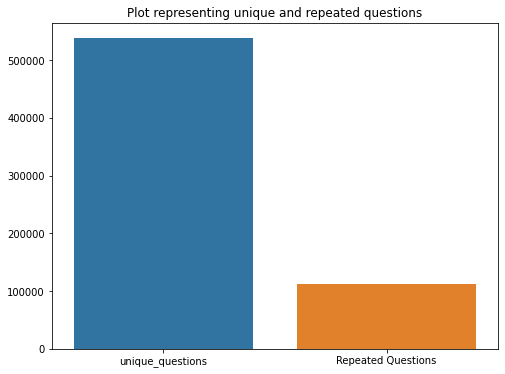

In [212]:
print('==> Question pairs are not Similar: {}%'.format(100 - round(df_train['is_duplicate'].mean()*100, 2)))
print('==> Question pairs are Similar: {}%'.format(round(df_train['is_duplicate'].mean()*100, 2)))
q_ids = pd.Series(list(df_train['qid1']) + list(df_train['qid2']))

unique_questions = len(np.unique(q_ids))
qs_more_than_onetime = np.sum(q_ids.value_counts() > 1)

print('==> Total number of  Unique Questions are: {}'.format(unique_questions))
print('==> Number of unique questions that appear more than one time: {} ({}%)'.format(qs_more_than_onetime,round(qs_more_than_onetime/unique_questions*100,2)))

x = ["unique_questions" , "Repeated Questions"]
y = [unique_questions , qs_more_than_onetime]

plt.figure(figsize=(8, 6))
plt.title ("Plot representing unique and repeated questions")
sns.barplot(x,y)
plt.show()


### Plotting Questions based on there frequency

==> Maximum number of times a single question is repeated: 157



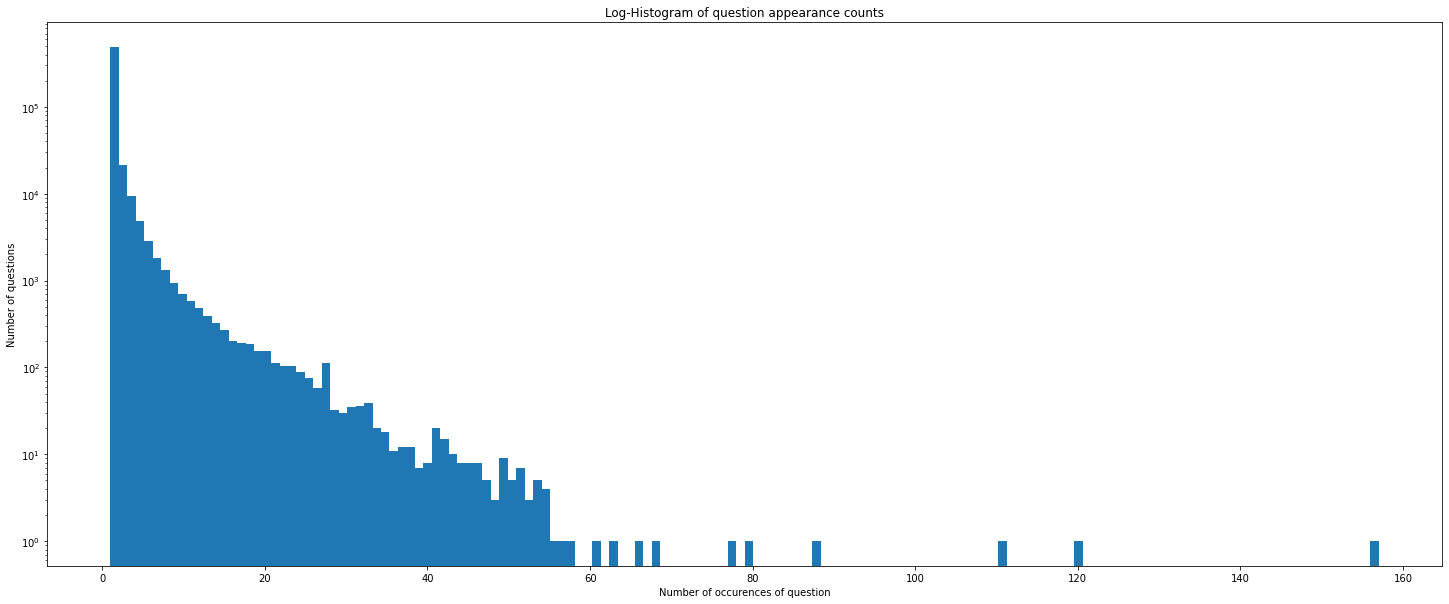

In [213]:
plt.figure(figsize=(25, 10))
plt.hist(q_ids.value_counts(), bins=150)
plt.yscale('log')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print('==> Maximum number of times a single question is repeated: {}\n'.format(max(q_ids.value_counts()))) 

### Equalizing the dataset

In [254]:
df_train_0 = df_train[df_train['is_duplicate'] == 0]
df_train_1 = df_train[df_train['is_duplicate'] == 1]

num_of_samples = 30000

# LIMITING DATASET DUE TO RAM ISSUES
# if df_train_0.shape[0] < df_train_1.shape[0]:
#   num_of_samples = df_train_0.shape[0]
# else:
#   num_of_samples = df_train_1.shape[0]

equal_df = pd.concat([df_train_0.sample(n=num_of_samples, random_state=1), df_train_1.sample(n=num_of_samples, random_state=1)])
x = equal_df.copy()
y = x['is_duplicate']
x = x.drop('is_duplicate', axis=1)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2, random_state = 42, stratify=y)

In [255]:
x_train.head()

,id,qid1,qid2,question1,question2
353274,353274,482303,482304,Will Angela Merkel resign after Munich and the...,Will Angela Merkel survive in office after the...
372197,372197,163630,502894,Is it legal for a campaign to work together co...,Holidays for startup teams. Is it possible for...
371342,371342,124694,230872,How easy would it be for Trump to overturn gay...,Will gay marriage be overturned with Donald Tr...
145221,145221,229655,229656,How can I defeat Nigeria?,Can Nigeria defeat Cameroon in a war?
176141,176141,271065,271066,Is there any service which offers supercompute...,Do you know people who don't use smart phones?


In [256]:
y_train = pd.DataFrame(y_train, columns=['is_duplicate'])
y_test = pd.DataFrame(y_test, columns=['is_duplicate'])

#### Shapes of train and test data

In [257]:
print('==> Shape of x_train:\t', x_train.shape)
print('==> Shape of x_test:\t', x_test.shape)
print('==> Shape of y_train:\t', y_train.shape)
print('==> Shape of y_test:\t', y_test.shape)

==> Shape of x_train:	 (48000, 5)
==> Shape of x_test:	 (12000, 5)
==> Shape of y_train:	 (48000, 1)
==> Shape of y_test:	 (12000, 1)


### Word count

In [258]:
x_train['Q1_word_count']= x_train['question1'].apply(lambda row : len(row.split(" ")))
x_train['Q2_word_count']= x_train['question2'].apply(lambda row : len(row.split(" ")))

x_test['Q1_word_count']= x_test['question1'].apply(lambda row : len(row.split(" ")))
x_test['Q2_word_count']= x_test['question2'].apply(lambda row : len(row.split(" ")))

### Common word count

In [259]:
def common(row):
    return len((set(row['question1'].lower().split())).intersection(set(row['question2'].lower().split())))

x_train['common_word_count'] = x_train.apply(common, axis=1)
x_test['common_word_count'] = x_test.apply(common, axis=1)


### Total word count

In [260]:
def total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return (len(w1) + len(w2))

x_train['word_total_count'] = x_train.apply(total, axis=1)
x_test['word_total_count'] = x_test.apply(total, axis=1)


### Word share ratio

In [261]:
def word_share(row):  
    return 1.0 * (row['common_word_count'] / row['word_total_count'])

x_train['shared_word_ratio'] = x_train.apply(word_share, axis=1)
x_test['shared_word_ratio'] = x_test.apply(word_share, axis=1)


### Word distribution

#### Question 1

==> Minimum words 1
==> Maximum words 73
==> Average num of words 10


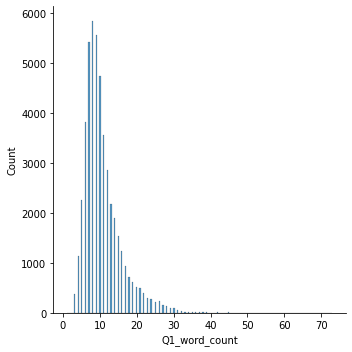

In [262]:
sns.displot(x_train['Q1_word_count'])
print('==> Minimum words',x_train['Q1_word_count'].min())
print('==> Maximum words',x_train['Q1_word_count'].max())
print('==> Average num of words',int(x_train['Q1_word_count'].mean()))

#### Question 2

==> Minimum words 1
==> Maximum words 237
==> Average num of words 10


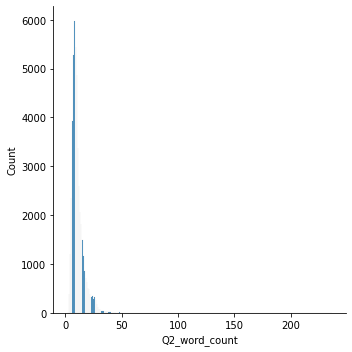

In [263]:
sns.displot(x_train['Q2_word_count'])
print('==> Minimum words',x_train['Q2_word_count'].min())
print('==> Maximum words',x_train['Q2_word_count'].max())
print('==> Average num of words',int(x_train['Q2_word_count'].mean()))

### Density Graph

#### Based on common word count

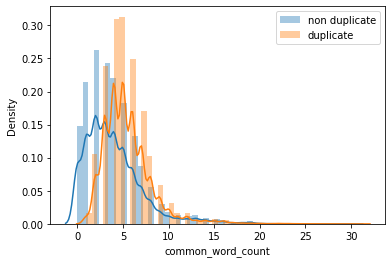

In [264]:
sns.distplot(x_train[y_train['is_duplicate'] == 0]['common_word_count'],label='non duplicate')
sns.distplot(x_train[y_train['is_duplicate'] == 1]['common_word_count'],label='duplicate')
plt.legend()
plt.show()

#### Based on Total words

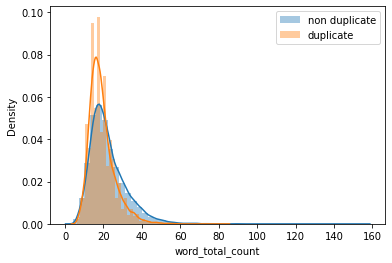

In [265]:
sns.distplot(x_train[y_train['is_duplicate'] == 0]['word_total_count'],label='non duplicate')
sns.distplot(x_train[y_train['is_duplicate'] == 1]['word_total_count'],label='duplicate')
plt.legend()
plt.show()


#### Based on word share

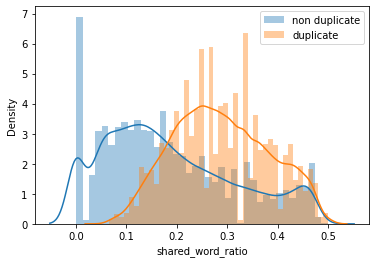

In [266]:
sns.distplot(x_train[y_train['is_duplicate'] == 0]['shared_word_ratio'],label='non duplicate')
sns.distplot(x_train[y_train['is_duplicate'] == 1]['shared_word_ratio'],label='duplicate')
plt.legend()
plt.show()

## Pre Processing

In [267]:
# Clean Text
stopword = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()
words = set(nltk.corpus.words.words())

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"www.\S+", "", text)
    text_links_removed = "".join([char for char in text if char not in string.punctuation])
    text_cleaned = " ".join([word for word in re.split('\W+', text_links_removed)
        if word not in stopword])
    text = " ".join([wn.lemmatize(word) for word in re.split('\W+', text_cleaned)])
    return text

In [268]:
x_train['clean_question1'] = x_train['question1'].apply(lambda x: clean_text(x))
x_train['clean_question2'] = x_train['question2'].apply(lambda x: clean_text(x))

x_test['clean_question1'] = x_test['question1'].apply(lambda x: clean_text(x))
x_test['clean_question2'] = x_test['question2'].apply(lambda x: clean_text(x))

### Word Cloud

In [269]:
wc_train_0 = x_train[y_train['is_duplicate'] == 0]
wc_train_1 = x_train[y_train['is_duplicate'] == 1]

p = np.dstack([wc_train_1['clean_question1'], wc_train_1['clean_question2']]).flatten()
n = np.dstack([wc_train_0["clean_question1"], wc_train_0["clean_question2"]]).flatten()

#### For Duplicate questions

Word Cloud for Duplicate Question pairs


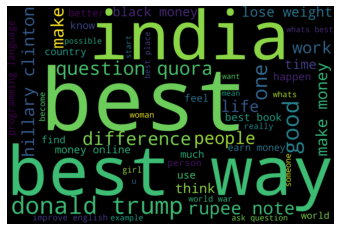

In [276]:
wc = WordCloud(width = 3000,height = 2000, background_color="black", max_words=50)
wc.generate(" ".join(p))
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### For non duplicate questions

Word Cloud for Duplicate Question pairs


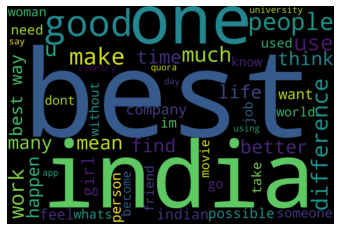

In [279]:
wc = WordCloud(width = 3000,height = 2000, background_color="black", max_words=50)
wc.generate(" ".join(n))
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# TF-IDF

#### XG Boost classifier: Word level

In [229]:
tfidf_word_vect = TfidfVectorizer(max_features=5000)
tfidf_word_vect.fit(pd.concat((x_train['clean_question1'],x_train['clean_question1'])).unique())
train_q1_trans_1 = tfidf_word_vect.transform(x_train['clean_question1'].values)
train_q2_trans_1 = tfidf_word_vect.transform(x_train['clean_question1'].values)
labels_1 = y_train['is_duplicate'].values

x_tfidf_1 = scipy.sparse.hstack((train_q1_trans_1,train_q2_trans_1))
y_tfidf_1 = labels_1

x_train_tfidf_1, x_test_tfidf_1, y_train_tfidf_1, y_test_tfidf_1 = train_test_split(x_tfidf_1, y_tfidf_1, test_size = 0.2, random_state = 42)

xgb_word_model = xgb.XGBClassifier(max_depth=50, 
                              n_estimators=80, 
                              learning_rate=0.01, 
                              colsample_bytree=.7, 
                              gamma=0, 
                              reg_alpha=4, 
                              objective='binary:logistic', 
                              eta=0.3, 
                              silent=1, 
                              subsample=0.8).fit(x_train_tfidf_1, y_train_tfidf_1) 

xgb_word_train_prediction = xgb_word_model.predict(x_train_tfidf_1)
xgb_word_test_prediction = xgb_word_model.predict(x_test_tfidf_1)

print('==> Training score:', f1_score(y_train_tfidf_1, xgb_word_train_prediction, average='macro'))
print('==> Validation score:', f1_score(y_test_tfidf_1, xgb_word_test_prediction, average='macro'))

print(classification_report(y_test_tfidf_1, xgb_word_test_prediction))

==> Training score: 0.6695417118671194
==> Validation score: 0.6425246853447593
              precision    recall  f1-score   support

           0       0.61      0.80      0.69      4757
           1       0.72      0.51      0.59      4843

    accuracy                           0.65      9600
   macro avg       0.66      0.65      0.64      9600
weighted avg       0.66      0.65      0.64      9600



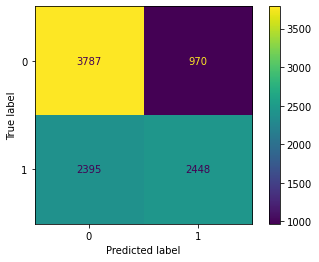

In [230]:
ConfusionMatrixDisplay.from_predictions(y_test_tfidf_1, xgb_word_test_prediction)

#### XG Boost classifier: NGram Level

In [231]:
tfidf_ngram_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_ngram_vect.fit(pd.concat((x_train['clean_question1'],x_train['clean_question1'])).unique())
train_q1_trans_2 = tfidf_ngram_vect.transform(x_train['clean_question1'].values)
train_q2_trans_2 = tfidf_ngram_vect.transform(x_train['clean_question1'].values)
labels_2 = y_train['is_duplicate'].values

x_tfidf_2 = scipy.sparse.hstack((train_q1_trans_2,train_q2_trans_2))
y_tfidf_2 = labels_2

x_train_tfidf_2, x_test_tfidf_2, y_train_tfidf_2, y_test_tfidf_2 = train_test_split(x_tfidf_2, y_tfidf_2, test_size = 0.2, random_state = 42)

xgb_ngram_model = xgb.XGBClassifier(max_depth=50, 
                                    n_estimators=80, 
                                    learning_rate=0.01, 
                                    colsample_bytree=.7, 
                                    gamma=0, 
                                    reg_alpha=4, 
                                    objective='binary:logistic', 
                                    eta=0.3, 
                                    silent=1, 
                                    subsample=0.8).fit(x_train_tfidf_2, y_train_tfidf_2) 

xgb_ngram_train_prediction = xgb_ngram_model.predict(x_train_tfidf_2)
xgb_ngram_test_prediction = xgb_ngram_model.predict(x_test_tfidf_2)

print('==> Training score:', f1_score(y_train_tfidf_2, xgb_ngram_train_prediction, average='macro'))
print('==> Validation score:', f1_score(y_test_tfidf_2, xgb_ngram_test_prediction, average='macro'))

print(classification_report(y_test_tfidf_2, xgb_ngram_test_prediction))

==> Training score: 0.5306664657152333
==> Validation score: 0.5227833144730167
              precision    recall  f1-score   support

           0       0.55      0.96      0.70      4757
           1       0.84      0.22      0.35      4843

    accuracy                           0.59      9600
   macro avg       0.69      0.59      0.52      9600
weighted avg       0.69      0.59      0.52      9600



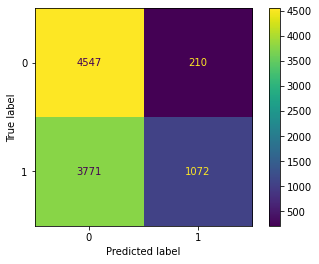

In [232]:
ConfusionMatrixDisplay.from_predictions(y_test_tfidf_2, xgb_ngram_test_prediction)

#### XG Boost classifier: NGram Char Level

In [233]:
tfidf_char_vect = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_char_vect.fit(pd.concat((x_train['clean_question1'],x_train['clean_question1'])).unique())
train_q1_trans_3 = tfidf_char_vect.transform(x_train['clean_question1'].values)
train_q2_trans_3 = tfidf_char_vect.transform(x_train['clean_question1'].values)
labels_3 = y_train['is_duplicate'].values

x_tfidf_3 = scipy.sparse.hstack((train_q1_trans_3,train_q2_trans_3))
y_tfidf_3 = labels_3

x_train_tfidf_3, x_test_tfidf_3, y_train_tfidf_3, y_test_tfidf_3 = train_test_split(x_tfidf_3, y_tfidf_3, test_size = 0.2, random_state = 42)

xgb_ngram_char_model = xgb.XGBClassifier(max_depth=50, 
                                    n_estimators=80, 
                                    learning_rate=0.01, 
                                    colsample_bytree=.7, 
                                    gamma=0, 
                                    reg_alpha=4, 
                                    objective='binary:logistic', 
                                    eta=0.3, 
                                    silent=1, 
                                    subsample=0.8).fit(x_train_tfidf_3, y_train_tfidf_3) 

xgb_ngram_char_train_prediction = xgb_ngram_char_model.predict(x_train_tfidf_3)
xgb_ngram_char_test_prediction = xgb_ngram_char_model.predict(x_test_tfidf_3)

print('==> Training score:', f1_score(y_train_tfidf_3, xgb_ngram_char_train_prediction, average='macro'))
print('==> Validation score:', f1_score(y_test_tfidf_3, xgb_ngram_char_test_prediction, average='macro'))

print(classification_report(y_test_tfidf_3, xgb_ngram_char_test_prediction))

==> Training score: 0.9154333014236559
==> Validation score: 0.6866590885281889
              precision    recall  f1-score   support

           0       0.67      0.72      0.69      4757
           1       0.70      0.65      0.68      4843

    accuracy                           0.69      9600
   macro avg       0.69      0.69      0.69      9600
weighted avg       0.69      0.69      0.69      9600



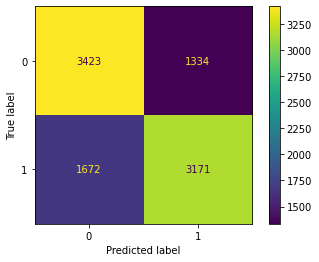

In [234]:
ConfusionMatrixDisplay.from_predictions(y_test_tfidf_3, xgb_ngram_char_test_prediction)

## Evaluation Metrics

# BERT

In [235]:
hub_url = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
embed = hub.KerasLayer(hub_url, trainable=False)

bert_q1 = x_train['clean_question1'].tolist()
bert_q2 = x_train['clean_question2'].tolist()
bert_shared_ratio = x_train['shared_word_ratio'].tolist()
bert_total_count = x_train['word_total_count'].tolist()
y_train = y_train['is_duplicate'].tolist()

bert_train_q1, bert_test_q1, bert_train_q2, bert_test_q2, bert_shared_ratio_train, bert_shared_ratio_test, bert_total_count_train, bert_total_count_test, bert_y_train, bert_y_test = train_test_split(bert_q1, bert_q2, bert_shared_ratio, bert_total_count, y_train, test_size=0.2, random_state=1, stratify=y_train)

In [236]:
input1 = Input(shape=(), dtype=tf.string)
input2 = Input(shape=(), dtype=tf.string)
input_wms = Input(shape=(1,), dtype=tf.float16)
input_wcd = Input(shape=(1,), dtype=tf.float16)

embed1 = embed(input1)
embed2 = embed(input2)

dist = Lambda(lambda x: K.sqrt(K.sum(K.square(x[0] - x[1]), axis=-1, keepdims=True)))([embed1,embed2])

concat = Concatenate(axis=1)([dist, input_wms, input_wcd])

hidden = Dense(9, activation="relu", kernel_regularizer=l2(1e-4))(concat)

out = Dense(1, activation="sigmoid", kernel_regularizer=l2(1e-4))(hidden)
model = Model(inputs=[input1, input2, input_wms, input_wcd], outputs=out)

In [237]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_22 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 keras_layer_4 (KerasLayer)     (None, 128)          124642688   ['input_21[0][0]',               
                                                                  'input_22[0][0]']               
                                                                                                  
 lambda_4 (Lambda)              (None, 1)            0           ['keras_layer_4[0][0]',    

In [238]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=adam, 
              loss='binary_crossentropy', 
              metrics=['acc', metrics.Precision(), metrics.Recall(), metrics.AUC()])


In [240]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model_chkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

evaluate = model.fit(x=[np.array(bert_train_q1), 
                        np.array(bert_train_q2), 
                        np.array(bert_shared_ratio_train), 
                        np.array(bert_total_count_train)],
          y=np.array(bert_y_train),
          batch_size=128,
          epochs=50,
          validation_data=([np.array(bert_test_q1), 
                            np.array(bert_test_q2), 
                            np.array(bert_shared_ratio_test), 
                            np.array(bert_total_count_test)], 
                           np.array(bert_y_test)),
          callbacks=[early_stop, model_chkpoint])

Epoch 1/50
294/300 [============================>.] - ETA: 0s - loss: 0.7941 - acc: 0.5225 - precision_6: 0.5120 - recall_6: 0.9686 - auc_6: 0.5182
Epoch 1: val_loss improved from inf to 0.71632, saving model to best_model.h5
300/300 [==============================] - 3s 12ms/step - loss: 0.7929 - acc: 0.5225 - precision_6: 0.5119 - recall_6: 0.9666 - auc_6: 0.5184 - val_loss: 0.7163 - val_acc: 0.5560 - val_precision_6: 0.5343 - val_recall_6: 0.8733 - val_auc_6: 0.5547
Epoch 2/50
298/300 [============================>.] - ETA: 0s - loss: 0.6933 - acc: 0.5731 - precision_6: 0.5616 - recall_6: 0.6650 - auc_6: 0.5841
Epoch 2: val_loss improved from 0.71632 to 0.68037, saving model to best_model.h5
300/300 [==============================] - 3s 11ms/step - loss: 0.6934 - acc: 0.5726 - precision_6: 0.5615 - recall_6: 0.6628 - auc_6: 0.5835 - val_loss: 0.6804 - val_acc: 0.5670 - val_precision_6: 0.5858 - val_recall_6: 0.4571 - val_auc_6: 0.6186
Epoch 3/50
295/300 [============================

In [243]:
train_loss = evaluate.history['loss']
train_acc = evaluate.history['acc']
train_precision = evaluate.history['precision_6']
train_recall = evaluate.history['recall_6']
train_auc = evaluate.history['auc_6']

val_loss = evaluate.history['val_loss']
val_acc = evaluate.history['val_acc']
val_precision = evaluate.history['val_precision_6']
val_recall = evaluate.history['val_recall_6']
val_auc = evaluate.history['val_auc_6']

epoches = [i for i in range(1,len(train_loss)+1)]


In [244]:
bert_y_pred = model.predict([x_test['clean_question1'], 
                            x_test['clean_question2'], 
                            x_test['shared_word_ratio'], 
                            x_test['word_total_count']])

In [245]:
norm_bert_y_pred = np.array([])
for x in bert_y_pred:
  if x[0] < 0.80:
    norm_bert_y_pred = np.append(norm_bert_y_pred, 0)
  else:
    norm_bert_y_pred = np.append(norm_bert_y_pred, 1)


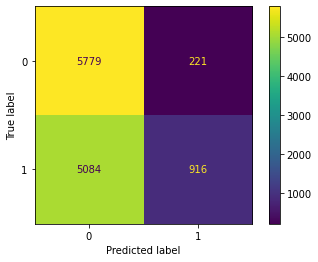

In [246]:
ConfusionMatrixDisplay.from_predictions(y_test['is_duplicate'], norm_bert_y_pred)

## Evaluation Metrics

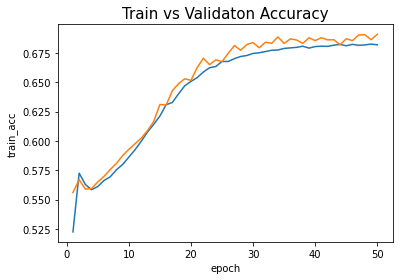

In [247]:
columns = ['epoch', 'train_acc', 'val_acc']
a_data = pd.DataFrame(np.column_stack([epoches, train_acc, val_acc]), columns=columns)
sns.lineplot(data=a_data, x="epoch", y="train_acc")
sns.lineplot(data=a_data, x="epoch", y="val_acc")
plt.title("Train vs Validaton Accuracy", fontsize = 15)
plt.show()

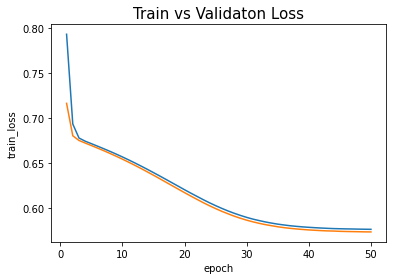

In [248]:
columns = ['epoch', 'train_loss', 'val_loss']
l_data = pd.DataFrame(np.column_stack([epoches, train_loss, val_loss]), columns=columns)
sns.lineplot(data=l_data, x="epoch", y="train_loss")
sns.lineplot(data=l_data, x="epoch", y="val_loss")
plt.title("Train vs Validaton Loss", fontsize = 15)
plt.show()

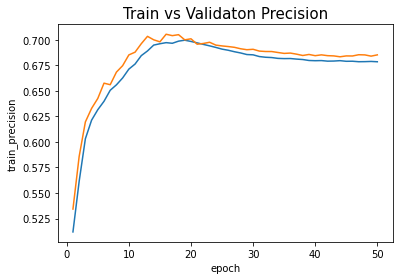

In [249]:
columns = ['epoch', 'train_precision', 'val_precision']
p_data = pd.DataFrame(np.column_stack([epoches, train_precision, val_precision]), columns=columns)
sns.lineplot(data=p_data, x="epoch", y="train_precision")
sns.lineplot(data=p_data, x="epoch", y="val_precision")
plt.title("Train vs Validaton Precision", fontsize = 15)
plt.show()

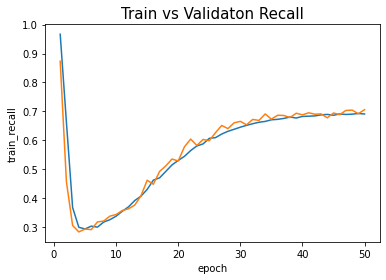

In [250]:
columns = ['epoch', 'train_recall', 'val_recall']
r_data = pd.DataFrame(np.column_stack([epoches, train_recall, val_recall]), columns=columns)
sns.lineplot(data=r_data, x="epoch", y="train_recall")
sns.lineplot(data=r_data, x="epoch", y="val_recall")
plt.title("Train vs Validaton Recall", fontsize = 15)
plt.show()

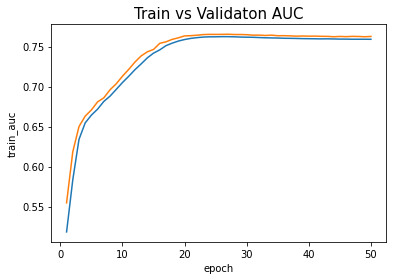

In [251]:
columns = ['epoch', 'train_auc', 'val_auc']
auc_data = pd.DataFrame(np.column_stack([epoches, train_auc, val_auc]), columns=columns)
sns.lineplot(data=auc_data, x="epoch", y="train_auc")
sns.lineplot(data=auc_data, x="epoch", y="val_auc")
plt.title("Train vs Validaton AUC", fontsize = 15)
plt.show()